### Looking out for the Galileon in pulsar timing array

We study the average power distributed in pulsar pairs in the sky through angular correlation or the overlap reduction function. We refer to the NANOGrav 12.5 year data set as a reference.

In [1]:
# typical python imports
import numpy as np
from scipy.special import sph_harm, spherical_jn, legendre, hyp2f1, gamma, factorial
from scipy.integrate import quad
from matplotlib import pyplot as plt

# ignoring ComplexWarning messages for discarding zero imaginary part
import warnings
warnings.filterwarnings('ignore')

#### NANOGrav pulsar timing array

We import the NANOGrav 12.5 year angular distributed power across pulsar pairs separated by an angle $\zeta$ across the sky.

In [2]:
data_loc = 'orf_n12p5.txt'
n12p5 = np.loadtxt(data_loc)

This is visualized below.

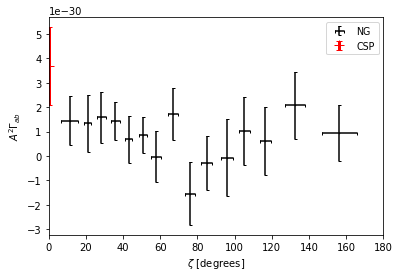

In [3]:
tta_rad = n12p5[0]
tta = tta_rad*180/np.pi
Dtta = n12p5[1]*180/np.pi
gma = n12p5[2]
Dgma = n12p5[3]

# amplitude of the common spectrum process

CSP = {'ave': 1.92e-15, 'err': max((2.67 - 1.92)*1e-15, (1.92 - 1.37)*1e-15)/2}
A2Gma_ng125 = {'ave': CSP['ave']**2, 'err': 2*CSP['ave']*CSP['err'] + CSP['err']**2}

# data plot

plt.errorbar(tta, gma, xerr = Dtta, yerr = Dgma, label = 'NG',
             fmt = 'k.', markersize = 1, ecolor = 'black', elinewidth = 1.5, capsize = 1.5)
plt.errorbar(0, A2Gma_ng125['ave'], yerr = A2Gma_ng125['err'], label = 'CSP',
             fmt = 'r+', markersize = 10, ecolor = 'red', elinewidth = 3, capsize = 3)
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$A^2 \Gamma_{ab}$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(0, 180)
plt.show()

Our goal is to understand the science that may explain this spatial correlation.

#### Stochastic gravitational wave background: phenomenology

We input the projection factors that build the power spectra of the scalar modes expected in a stochastic gravitational wave background.

In [4]:
# second derivative of the Bessel function

def D2jl(l, x):
    return (-2*x*spherical_jn(l, x, derivative = True) \
            - (x**2 - l*(l + 1))*spherical_jn(l, x))/(x**2)

# TT tensor

def R_T(x, l, v):
    return np.exp(1j*x/v)*spherical_jn(l, x)/(v*(x**2))

def ReR_T(x, l, v):
    return np.real(R_T(x, l, v))

def ImR_T(x, l, v):
    return np.imag(R_T(x, l, v))

def F_T(l, v, fD):
    r = 2*np.pi*fD*v
    ReInt = quad(ReR_T, 0, r, args = (l, v), limit = int(1e5))[0]
    ImInt = quad(ImR_T, 0, r, args = (l, v), limit = int(1e5))[0]
    Il = ReInt + 1j*ImInt
    Nl = np.sqrt(factorial(l + 2)/(2*factorial(l - 2)))
    return (1j/2)*Nl*Il

# scalar longitudinal

def R_SL(x, l, v):
    return np.exp(1j*x/v)*D2jl(l, x)/v

def ReR_SL(x, l, v):
    return np.real(R_SL(x, l, v))

def ImR_SL(x, l, v):
    return np.imag(R_SL(x, l, v))

def F_SL(l, v, fD):
    r = 2*np.pi*fD*v
    ReInt = quad(ReR_SL, 0, r, args = (l, v), limit = int(1e5))[0]
    ImInt = quad(ImR_SL, 0, r, args = (l, v), limit = int(1e5))[0]
    return -(1j/2)*(ReInt + 1j*ImInt)

# scalar transverse

def R_ST(x, l, v):
    return -(1/np.sqrt(2))*np.exp(1j*x/v)*(D2jl(l, x) + spherical_jn(l, x))/v

def ReR_ST(x, l, v):
    return np.real(R_ST(x, l, v))

def ImR_ST(x, l, v):
    return np.imag(R_ST(x, l, v))

def F_ST(l, v, fD):
    r = 2*np.pi*fD*v
    ReInt = quad(ReR_ST, 0, r, args = (l, v), limit = int(1e5))[0]
    ImInt = quad(ImR_ST, 0, r, args = (l, v), limit = int(1e5))[0]
    return -(1j/2)*(ReInt + 1j*ImInt)

The scalar power spectra and the overlap reduction function that come with it can be constructed as follows.

In [5]:
# the power spectra (in spherical harmonic space)

def Cl_T(l, v, fD):
    Proj_Fact = F_T(l, v, fD)
    return 32*(np.pi**2)*(Proj_Fact*np.conj(Proj_Fact))

def Cl_SL(l, v, fD):
    Proj_Fact = F_SL(l, v, fD)
    return 32*(np.pi**2)*(Proj_Fact*np.conj(Proj_Fact))

def Cl_ST(l, v, fD):
    Proj_Fact = F_ST(l, v, fD)
    return 32*(np.pi**2)*(Proj_Fact*np.conj(Proj_Fact))

We also put in below the 'zero lag' integrals.

In [6]:
# tensor

def gaa_T(t, v, fD):
    vcos = 1 + v*np.cos(t)
    return 2*np.pi*(np.sin(t)**5)*(np.sin(np.pi*fD*vcos)**2)/ \
           (vcos**2)

def Gaa_T(v, fD):
    return quad(gaa_T, 0, np.pi, args = (v, fD), limit = int(1e5))[0]

# scalars

def gaa_ST(t, v, fD):
    vcos = 1 + v*np.cos(t)
    return 2*np.pi*(np.sin(t)**5)*(np.sin(np.pi*fD*vcos)**2)/ \
           (vcos**2)

def Gaa_ST(v, fD):
    return quad(gaa_ST, 0, np.pi, args = (v, fD), limit = int(1e5))[0]

def gaa_SL(t, v, fD):
    vcos = 1 + v*np.cos(t)
    return 4*np.pi*np.sin(t)*(np.cos(t)**4)*(np.sin(np.pi*fD*vcos)**2)/ \
           (vcos**2)

def Gaa_SL(v, fD):
    return quad(gaa_SL, 0, np.pi, args = (v, fD), limit = int(1e5))[0]

It is useful to refer to the quadrupolar transverse-traceless tensor and the infinite distance scalar polarizations' power spectra. The TT PS is given by the Hellings-Down curve while the infinite distance scalar PS is given (in the next line in its multipolar form).

In [7]:
def Cl_HD(l):
    corr = np.sqrt(4*np.pi) # correction factor for norm conventions
    return corr*8*(np.pi**(3/2))/((l + 2)*(l + 1)*l*(l - 1))

def I2_Dinf(l, v):
    n = 2
    hyp = hyp2f1((l + 1 - n)/2, (l + 2 - n)/2, l + (3/2), v**2)
    gam = gamma(l + 1 - n)/gamma(l + (3/2))
    nrm =  ((1j*v/2)**(l + 1 - n))*np.sqrt(np.pi)/(2**n)
    return nrm*gam*hyp

def F_T_Dinf(l, v):
    Il = I2_Dinf(l, v)
    Nl = np.sqrt(factorial(l + 2)/(2*factorial(l - 2)))
    return (1j/(2*v))*Nl*Il

def Cl_T_Dinf(l, v):
    Proj_Fact = F_T_Dinf(l, v)
    return 32*(np.pi**2)*(Proj_Fact*np.conj(Proj_Fact))

def hyp2f1reg(a, b, c, z):
    return hyp2f1(a, b, c, z)/gamma(c)

def I_Dinf(l, v):
    l1 = l + 1
    prefactor = (1/(2**l1))*np.sqrt(np.pi)*((1j*v)**(l + 1))
    gammafact = gamma(l + 1)
    hyperfact = hyp2f1reg((l + 1)/2, (l + 2)/2, l + (3/2), v**2)
    return prefactor*gammafact*hyperfact
    
def F_SL_Dinf(l, v):
    if l == 0:
        return 1/(2*(v**2))
    elif l == 1:
        return 1j/(6*v)
    else:
        return (1j/(2*(v**3)))*I_Dinf(l, v)
    
def F_ST_Dinf(l, v):
    if l == 0:
        return -1/(2*np.sqrt(2)*(v**2))
    elif l == 1:
        return -1j/(6*np.sqrt(2)*v)
    else:
        return -(1/(2*np.sqrt(2)))*1j*((1 - v**2)/(v**3))*I_Dinf(l, v)
    
def Cl_SL_Dinf(l, v):
    Proj_Fact = F_SL_Dinf(l, v)
    return 32*(np.pi**2)*(Proj_Fact*np.conj(Proj_Fact))

def Cl_ST_Dinf(l, v):
    Proj_Fact = F_ST_Dinf(l, v)
    return 32*(np.pi**2)*(Proj_Fact*np.conj(Proj_Fact))

We first generate the Hellings-Downs multipoles as a reference for all plots.

In [8]:
l100 = np.arange(0, 101) # number of multipoles
Cls_HD = np.array([np.real(Cl_HD(l)) for l in l100[2:]]) # HD multipoles

We compute the multipoles for various velocities of the tensor and scalar transverse polarizations. Tensor $C_l$s are needed for correct normalization. *Next line will take a few minutes.*

In [9]:
def Cls_T_varfD(v, fD_lst):
    Cls = []
    for fD in fD_lst:
        Cls.append([np.real(Cl_T(l, v, fD)) for l in l100[2:]])
    return Cls

def Cls_T_Dinf(v):
    Cls = [np.real(Cl_T_Dinf(l, v)) for l in l100[2:]]
    return Cls

def Cls_ST_varfD(v, fD_lst):
    Cls = []
    for fD in fD_lst:
        Cls.append([np.real(Cl_ST(l, v, fD)) for l in l100])
    return Cls

def Cls_ST_Dinf(v):
    Cls = [np.real(Cl_ST_Dinf(l, v)) for l in l100]
    return Cls

fD_lst = [100, 500]

# # # v = 0.99
Cls_ST_v1 = Cls_ST_varfD(0.99, fD_lst)
Cls_ST_v1_Dinf = Cls_ST_Dinf(0.99)

# # # v = 1/2
Cls_ST_v12 = Cls_ST_varfD(1/2, fD_lst)
Cls_ST_v12_Dinf = Cls_ST_Dinf(1/2)

# # # v = 0.01
Cls_ST_v01 = Cls_ST_varfD(0.01, fD_lst)
Cls_ST_v01_Dinf = Cls_ST_Dinf(0.01)

Here is a plot of the multipoles for each velocity.

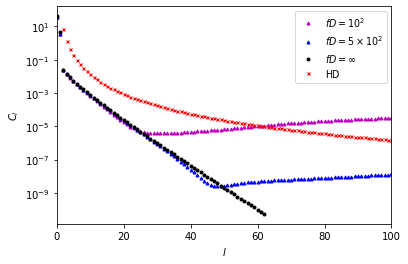

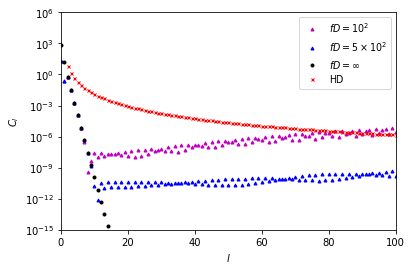

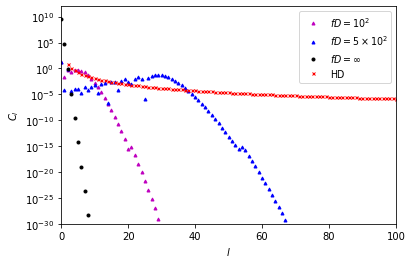

In [10]:
Cl_ST_D100 = np.array(Cls_ST_v1[0])
Cl_ST_D500 = np.array(Cls_ST_v1[1])
Cl_ST_Dinf = np.array(Cls_ST_v1_Dinf)
plt.plot(l100, Cl_ST_D100, 'm^', markersize = 3, label = r'$fD = 10^2$')
plt.plot(l100, Cl_ST_D500, 'b^', markersize = 3, label = r'$fD = 5 \times 10^2$')
plt.plot(l100, Cl_ST_Dinf, 'ko', markersize = 3, label = r'$fD = \infty$')
plt.plot(l100[2:], Cls_HD, 'rx', markersize = 3, label = r'HD')
plt.yscale("log")
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(min(l100), max(l100))
plt.show()

Cl_ST_D100 = np.array(Cls_ST_v12[0])
Cl_ST_D500 = np.array(Cls_ST_v12[1])
Cl_ST_Dinf = np.array(Cls_ST_v12_Dinf)
plt.plot(l100, Cl_ST_D100, 'm^', markersize = 3, label = r'$fD = 10^2$')
plt.plot(l100, Cl_ST_D500, 'b^', markersize = 3, label = r'$fD = 5 \times 10^2$')
plt.plot(l100, Cl_ST_Dinf, 'ko', markersize = 3, label = r'$fD = \infty$')
plt.plot(l100[2:], Cls_HD, 'rx', markersize = 3, label = r'HD')
plt.yscale("log")
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(min(l100), max(l100))
plt.ylim(1e-15, 1e6)
plt.show()

Cl_ST_D100 = np.array(Cls_ST_v01[0])
Cl_ST_D500 = np.array(Cls_ST_v01[1])
Cl_ST_Dinf = np.array(Cls_ST_v01_Dinf)
plt.plot(l100, Cl_ST_D100, 'm^', markersize = 3, label = r'$fD = 10^2$')
plt.plot(l100, Cl_ST_D500, 'b^', markersize = 3, label = r'$fD = 5 \times 10^2$')
plt.plot(l100, Cl_ST_Dinf, 'ko', markersize = 3, label = r'$fD = \infty$')
plt.plot(l100[2:], Cls_HD, 'rx', markersize = 3, label = r'HD')
plt.yscale("log")
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(min(l100), max(l100))
plt.ylim(1e-30, 1e12)
plt.show()

The overlap reduction functions corresponding to these can be calculated as follows.

In [11]:
lmax = 30
tta_space = np.linspace(0, np.pi, lmax + 1)[1:] # excludes zeta = 0
Gab_HD = sum([(2*l + 1)*Cl_HD(l)/(4*np.pi) for l in np.arange(2, lmax + 1)])
CTta_HD = np.array([sum([(2*l + 1)*Cl_HD(l)*legendre(l)(np.cos(phi))/(4*np.pi) \
                    for l in np.arange(2, lmax + 1)]) for phi in tta_space])*(0.5/Gab_HD)

def CTta(Cls_S):
    '''for the scalar polarizations'''
    
    terms = [sum([(2*l + 1)*Cls_S[l]*legendre(l)(np.cos(phi))/(4*np.pi) \
                 for l in np.arange(0, lmax + 1)]) for phi in tta_space]
    orf = np.array(terms)
    Orf = (orf/Gab_HD)*0.5
    return Orf

So, here are the plots.

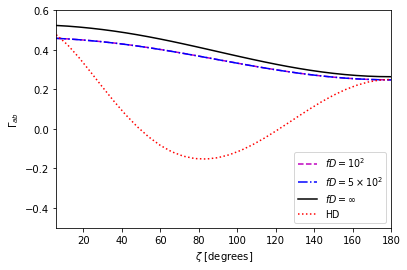

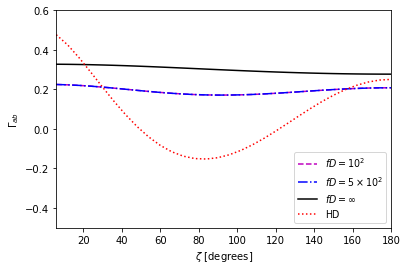

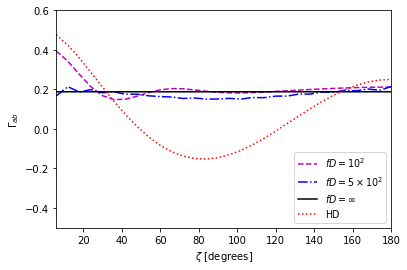

In [13]:
# v = 0.99
Ctta_D100 = CTta(Cls_ST_v1[0])
Ctta_D500 = CTta(Cls_ST_v1[1])
Ctta_Dinf = CTta(Cls_ST_v1_Dinf)
plt.plot(tta_space*180/np.pi, Ctta_D100, 'm--', label = r'$fD = 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_D500, 'b-.', label = r'$fD = 5 \times 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_Dinf, 'k-', label = r'$fD = \infty$')
plt.plot(tta_space*180/np.pi, CTta_HD, 'r:', label = r'HD')
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\Gamma_{ab}$')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(6, 180)
plt.ylim(-0.5, 0.6)
plt.show()

# v = 1/2
Ctta_D100 = CTta(Cls_ST_v12[0])
Ctta_D500 = CTta(Cls_ST_v12[1])
Ctta_Dinf = CTta(Cls_ST_v12_Dinf)
plt.plot(tta_space*180/np.pi, Ctta_D100, 'm--', label = r'$fD = 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_D500, 'b-.', label = r'$fD = 5 \times 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_Dinf/20, 'k-', label = r'$fD = \infty$')
plt.plot(tta_space*180/np.pi, CTta_HD, 'r:', label = r'HD')
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\Gamma_{ab}$')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(6, 180)
plt.ylim(-0.5, 0.6)
plt.show()

# v = 0.01
Ctta_D100 = CTta(Cls_ST_v01[0])
Ctta_D500 = CTta(Cls_ST_v01[1])
Ctta_Dinf = CTta(Cls_ST_v01_Dinf)
plt.plot(tta_space*180/np.pi, Ctta_D100, 'm--', label = r'$fD = 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_D500, 'b-.', label = r'$fD = 5 \times 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_Dinf/2e8, 'k-', label = r'$fD = \infty$')
plt.plot(tta_space*180/np.pi, CTta_HD, 'r:', label = r'HD')
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\Gamma_{ab}$')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(6, 180)
plt.ylim(-0.5, 0.6)
plt.show()

We repeat the calculation for the scalar longitudinal polarization.

In [14]:
l100 = np.arange(0, 101)
def Cls_SL_varfD(v, fD_lst):
    Cls = []
    for fD in fD_lst:
        Cls.append([np.real(Cl_SL(l, v, fD)) for l in l100])
    return Cls

def Cls_SL_Dinf(v):
    Cls = [np.real(Cl_SL_Dinf(l, v)) for l in l100]
    return Cls

fD_lst = [100, 500]

# # v = 0.99
Cls_SL_v1 = Cls_SL_varfD(0.99, fD_lst)
Cls_SL_v1_Dinf = Cls_SL_Dinf(0.99)

# # v = 1/2
Cls_SL_v12 = Cls_SL_varfD(1/2, fD_lst)
Cls_SL_v12_Dinf = Cls_SL_Dinf(1/2)

# # v = 0.01
Cls_SL_v01 = Cls_SL_varfD(0.01, fD_lst)
Cls_SL_v01_Dinf = Cls_SL_Dinf(0.01)

Here's the multipoles per velocity.

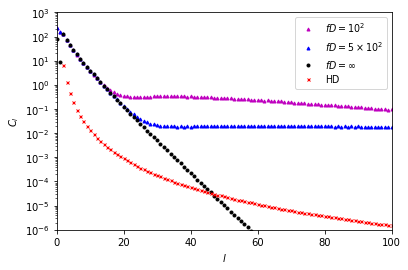

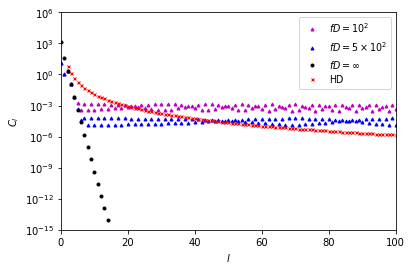

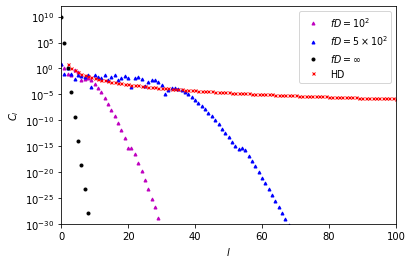

In [15]:
Cl_SL_D100 = np.array(Cls_SL_v1[0])
Cl_SL_D500 = np.array(Cls_SL_v1[1])
Cl_SL_Dinf = np.array(Cls_SL_v1_Dinf)
plt.plot(l100, Cl_SL_D100, 'm^', markersize = 3, label = r'$fD = 10^2$')
plt.plot(l100, Cl_SL_D500, 'b^', markersize = 3, label = r'$fD = 5 \times 10^2$')
plt.plot(l100, Cl_SL_Dinf, 'ko', markersize = 3, label = r'$fD = \infty$')
plt.plot(l100[2:], Cls_HD, 'rx', markersize = 3, label = r'HD')
plt.yscale("log")
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(min(l100), max(l100))
plt.ylim(1e-6, 1e3)
plt.show()

Cl_SL_D100 = np.array(Cls_SL_v12[0])
Cl_SL_D500 = np.array(Cls_SL_v12[1])
Cl_SL_Dinf = np.array(Cls_SL_v12_Dinf)
plt.plot(l100, Cl_SL_D100, 'm^', markersize = 3, label = r'$fD = 10^2$')
plt.plot(l100, Cl_SL_D500, 'b^', markersize = 3, label = r'$fD = 5 \times 10^2$')
plt.plot(l100, Cl_SL_Dinf, 'ko', markersize = 3, label = r'$fD = \infty$')
plt.plot(l100[2:], Cls_HD, 'rx', markersize = 3, label = r'HD')
plt.yscale("log")
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(min(l100), max(l100))
plt.ylim(1e-15, 1e6)
plt.show()

Cl_SL_D100 = np.array(Cls_SL_v01[0])
Cl_SL_D500 = np.array(Cls_SL_v01[1])
Cl_SL_Dinf = np.array(Cls_SL_v01_Dinf)
plt.plot(l100, Cl_SL_D100, 'm^', markersize = 3, label = r'$fD = 10^2$')
plt.plot(l100, Cl_SL_D500, 'b^', markersize = 3, label = r'$fD = 5 \times 10^2$')
plt.plot(l100, Cl_SL_Dinf, 'ko', markersize = 3, label = r'$fD = \infty$')
plt.plot(l100[2:], Cls_HD, 'rx', markersize = 3, label = r'HD')
plt.yscale("log")
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(min(l100), max(l100))
plt.ylim(1e-30, 1e12)
plt.show()

Lastly, here are the overlap reduction functions.

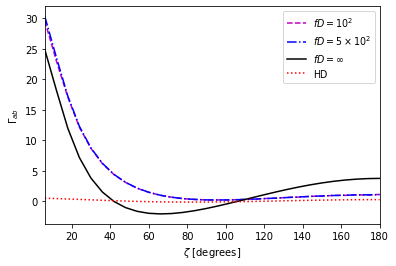

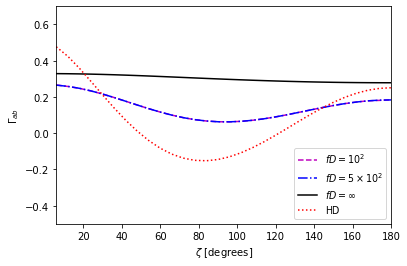

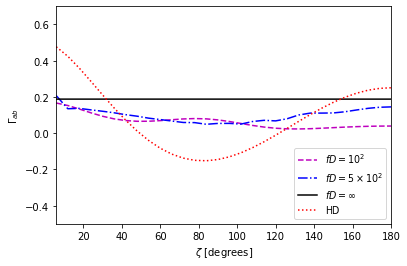

In [16]:
# v = 0.99
Ctta_D100 = CTta(Cls_SL_v1[0])
Ctta_D500 = CTta(Cls_SL_v1[1])
Ctta_Dinf = CTta(Cls_SL_v1_Dinf)
plt.plot(tta_space*180/np.pi, Ctta_D100, 'm--', label = r'$fD = 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_D500, 'b-.', label = r'$fD = 5 \times 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_Dinf, 'k-', label = r'$fD = \infty$')
plt.plot(tta_space*180/np.pi, CTta_HD, 'r:', label = r'HD')
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\Gamma_{ab}$')
plt.legend(loc = 'upper right', prop = {'size': 9.5})
plt.xlim(6, 180)
plt.show()

# v = 1/2
Ctta_D100 = CTta(Cls_SL_v12[0])
Ctta_D500 = CTta(Cls_SL_v12[1])
Ctta_Dinf = CTta(Cls_SL_v12_Dinf)
plt.plot(tta_space*180/np.pi, Ctta_D100, 'm--', label = r'$fD = 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_D500, 'b-.', label = r'$fD = 5 \times 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_Dinf/40, 'k-', label = r'$fD = \infty$')
plt.plot(tta_space*180/np.pi, CTta_HD, 'r:', label = r'HD')
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\Gamma_{ab}$')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(6, 180)
plt.ylim(-0.5, 0.7)
plt.show()

# v = 0.01
Ctta_D100 = CTta(Cls_SL_v01[0])
Ctta_D500 = CTta(Cls_SL_v01[1])
Ctta_Dinf = CTta(Cls_SL_v01_Dinf)
plt.plot(tta_space*180/np.pi, Ctta_D100, 'm--', label = r'$fD = 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_D500, 'b-.', label = r'$fD = 5 \times 10^2$')
plt.plot(tta_space*180/np.pi, Ctta_Dinf/4e8, 'k-', label = r'$fD = \infty$')
plt.plot(tta_space*180/np.pi, CTta_HD, 'r:', label = r'HD')
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\Gamma_{ab}$')
plt.legend(loc = 'lower right', prop = {'size': 9.5})
plt.xlim(6, 180)
plt.ylim(-0.5, 0.7)
plt.show()

Given a velocity $v$, we compute the autocorrelations of the SL using the power spectrum and compare with the real space formalism.

In [17]:
lmax = 30
Lmax = 1000

# the autocorrelations
Gab_SL_PS = np.real(sum([(2*l + 1)*Cl_SL(l, v = 0.6, fD = 100)/(4*np.pi) for l in np.arange(0, lmax + 1)]))
Gaa_SL_PS = np.real(sum([(2*l + 1)*Cl_SL(l, v = 0.6, fD = 100)/(4*np.pi) for l in np.arange(0, Lmax + 1)]))

# normalizing
print('\Gamma_{aa} =', Gaa_SL_PS*0.5/Gab_SL_PS)

\Gamma_{aa} = 0.9771458886972646


Result from the real space formalism is given by...

In [18]:
Gaa_SL(v = 0.6, fD = 100)*0.5/Gab_SL_PS

0.9771458798121535

#### Stochastic gravitational wave background: Data analysis

In this section, we setup the likelihood that a particular polarization fit into the pulsar timing array data. We calculate the overlap reduction function of each scalar polarizations and their combination as the galileon.

In [19]:
# the overlap reduction function, evaluated on the data

lmax = 30
l_arr = np.arange(0, lmax + 1)
Gab_HD = sum([(2*l + 1)*Cl_HD(l)/(4*np.pi) for l in np.arange(2, lmax + 1)])
Gaa_HD = Gaa_T(v = 1 - 1e-10, fD = 1e5)

def CTta_ng125(Cls_S):
    '''for the scalar polarizations'''
    
    terms = [sum([(2*l + 1)*Cls_S[l]*legendre(l)(np.cos(phi))/(4*np.pi) \
                 for l in np.arange(0, lmax + 1)]) for phi in tta_rad]
    orf = np.array(terms)
    Orf = (orf/Gab_HD)*0.5
    return Orf

def Ctta_ST(v, fD):
    Cls_ST = np.array([Cl_ST(l, v, fD) for l in np.arange(0, lmax + 1)])
    Cls_TT = np.array([Cl_T(l, v, fD) for l in np.arange(2, lmax + 1)])
    Orf_ST = CTta_ng125(Cls_ST)
    return Orf_ST

def Ctta_SL(v, fD):
    Cls_SL = np.array([Cl_SL(l, v, fD) for l in np.arange(0, lmax + 1)])
    Cls_TT = np.array([Cl_T(l, v, fD) for l in np.arange(2, lmax + 1)])
    Orf_SL = CTta_ng125(Cls_SL)
    return Orf_SL

def chi2_ST(v, A2, fD = 100):
    model = np.real(A2*Ctta_ST(v, fD))
    chi2 = sum(((model - gma)/Dgma)**2)
    
    model_csp = A2*Gaa_ST(v, fD)/Gaa_HD
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2
    return chi2 + chi2_csp

def loglike_ST(v, A2, fD = 100):
    return -0.5*chi2_ST(v, A2, fD)

def chi2_SL(v, A2, fD = 100):
    model = np.real(A2*Ctta_SL(v, fD))
    chi2 = sum(((model - gma)/Dgma)**2)
    
    model_csp = A2*Gaa_SL(v, fD)/Gaa_HD
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2
    return chi2 + chi2_csp

def loglike_SL(v, A2, fD = 100):
    return -0.5*chi2_SL(v, A2, fD)

# the overlap reduction function for the galileon, and the systematic monopole

def Ctta_gal(v, fD):
    v_fact = ((1 - v**2)/np.sqrt(2))**2
    Cls_gal = np.array([Cl_ST(l, v, fD) + v_fact*Cl_SL(l, v, fD) for l in np.arange(0, lmax + 1)])
    Orf_gal = CTta_ng125(Cls_gal)
    return Orf_gal

def chi2_gal(v, A2, fD = 100):
    model = np.real(A2*Ctta_gal(v, fD))
    chi2 = sum(((model - gma)/Dgma)**2)
    
    v_fact = ((1 - v**2)/np.sqrt(2))**2
    model_csp = A2*(Gaa_ST(v, fD) + v_fact*Gaa_SL(v, fD))/Gaa_HD
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2
    return chi2

def loglike_gal(v, A2, fD = 100):
    return -0.5*chi2_gal(v, A2, fD)

# the GW monopole

def loglike_mon(A2):
    model = A2*0.5
    chi2 = sum(((model - gma)/Dgma)**2)
    
    model_csp = A2
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2
    return -0.5*(chi2 + chi2_csp)

# the Hellings-Down curve and its likelihood

def HD_curve(theta):
    cosfact = (1 - np.cos(theta))/2
    return (1/2) - (1/4)*cosfact + (3/2)*cosfact*np.log(cosfact)

def chi2_HD(A2):
    model = A2*HD_curve(tta_rad)
    chi2 = sum(((model - gma)/Dgma)**2)
    
    model_csp = A2
    chi2_csp = ((model_csp - A2Gma_ng125['ave'])/A2Gma_ng125['err'])**2
    return chi2 + chi2_csp

def loglike_HD(A2):
    return -0.5*chi2_HD(A2)

We study the deviation of the model provided by each polarization with data by means of Bayesian analysis. We make use of the community code ``cobaya`` and ``getdist`` for this purpose.

In [17]:
# from cobaya.run import run
# from cobaya.yaml import yaml_load_file

The inputs can be provided as python dictionary, but we opt to instead provide it as a ``yaml`` file since this is easier to run on a cluster. We demonstrate simply for the GW monopole and the HD.

In [18]:
# # importing the log-likelihood of the monopole/HD
# info_mon = yaml_load_file("mon_ng12p5_csp_normHD.yaml")
# info_hd = yaml_load_file("hd_ng12p5_csp_normHD.yaml")

# # run MCMC, as encoded in yaml file
# updated_info, sampler = run(info_hd)

Here we study the resulting posteriors using ``getdist``.

In [20]:
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt
import os # requires *full path*

folder_file_1 = 'chains_csp_normHD/ST'
folder_file_2 = 'chains_csp_normHD/SL'
folder_file_3 = 'chains_csp_normHD/gal'
folder_file_4 = 'chains_csp_normHD/mon'
folder_file_5 = 'chains_csp_normHD/hd'
gdsamples_1 = loadMCSamples(os.path.abspath(folder_file_1))
gdsamples_2 = loadMCSamples(os.path.abspath(folder_file_2))
gdsamples_3 = loadMCSamples(os.path.abspath(folder_file_3))
gdsamples_4 = loadMCSamples(os.path.abspath(folder_file_4))
gdsamples_5 = loadMCSamples(os.path.abspath(folder_file_5))

# get statistics
stats_1 = gdsamples_1.getMargeStats()
stats_2 = gdsamples_2.getMargeStats()
stats_3 = gdsamples_3.getMargeStats()
stats_4 = gdsamples_4.getMargeStats()
stats_5 = gdsamples_5.getMargeStats()

# likelihood statistics for best fit
lstats_1 = gdsamples_1.getLikeStats()
lstats_2 = gdsamples_2.getLikeStats()
lstats_3 = gdsamples_3.getLikeStats()
lstats_4 = gdsamples_4.getLikeStats()
lstats_5 = gdsamples_5.getLikeStats()

/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/ST.1.txt
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/ST.2.txt
Removed no burn in
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/SL.1.txt
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/SL.2.txt
Removed no burn in
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/gal.1.txt
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/gal.2.txt
Removed no burn in
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/mon.2.txt
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/mon.1.txt
Removed no burn in
/home/reggiebernardo/research_notebooks/python/nanograv/galileon/pubfiles/chains_csp_normHD/hd.2.txt
/home/reggi

We can view the posterior distributions as follows.

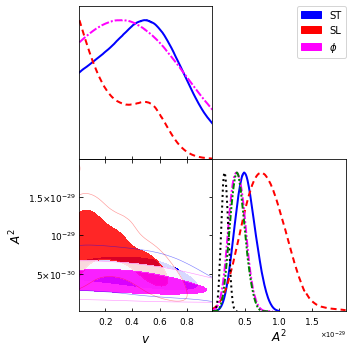

In [21]:
gdplot = gdplt.get_subplot_plotter(width_inch = 5)
gdplot.triangle_plot([gdsamples_1, gdsamples_2, gdsamples_3, gdsamples_4, gdsamples_5],
                     ["v", "A2"],
                     contour_ls = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))],
                     contour_lws = [2, 2, 2, 2, 2],
                     contour_colors = [((1,1,1), 'blue'), ((1,1,1), 'red'),
                                       ((1,1,1), 'magenta'),
                                       ((1,1,1), 'black'), ((1,1,1), 'green')],
                     filled = True,
                     #title_limit = 1,
                     legend_loc = 'upper right',
                     legend_labels = ['ST', 'SL', r'$\phi$', 'GW mon', 'HD'],
                     param_limits = {'A2': (1e-31, 2e-29)})

We look at their mean fits below.

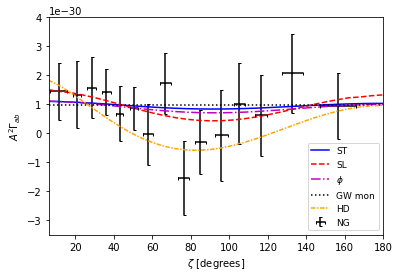

In [22]:
lmax = 30
tta_space = np.linspace(0, np.pi, lmax + 1)[1:] # excludes zeta = 0

def CTta(Cls_S):
    '''for the scalar polarizations'''
    
    terms = [sum([(2*l + 1)*Cls_S[l]*legendre(l)(np.cos(phi))/(4*np.pi) \
                 for l in np.arange(0, lmax + 1)]) for phi in tta_space]
    orf = np.array(terms)
    Orf = (orf/Gab_HD)*0.5
    return Orf

def orf_ST(v, A2, fD = 100):
    Cls_ST = np.array([Cl_ST(l, v, fD) for l in np.arange(0, lmax + 1)])
    Cls_TT = np.array([Cl_T(l, v, fD) for l in np.arange(2, lmax + 1)])
    Orf_ST = CTta(Cls_ST)
    return np.real(A2*Orf_ST)

def orf_SL(v, A2, fD = 100):
    Cls_SL = np.array([Cl_SL(l, v, fD) for l in np.arange(0, lmax + 1)])
    Cls_TT = np.array([Cl_T(l, v, fD) for l in np.arange(2, lmax + 1)])
    Orf_SL = CTta(Cls_SL)
    return np.real(A2*Orf_SL)

def orf_gal(v, A2, fD = 100):
    v_fact = ((1 - v**2)/np.sqrt(2))**2
    Cls_gal = np.array([Cl_ST(l, v, fD) + v_fact*Cl_SL(l, v, fD) \
                        for l in np.arange(0, lmax + 1)])
    Cls_TT = np.array([Cl_T(l, v, fD) for l in np.arange(2, lmax + 1)])
    Orf_gal = CTta(Cls_gal)
    return np.real(A2*Orf_gal)

# ST best fit

orf_ST_bf = orf_ST(v = stats_1.parWithName('v').mean, \
                   A2 = stats_1.parWithName('A2').mean, fD = 100)
plt.plot(tta_space*180/np.pi, orf_ST_bf, 'b-', label = 'ST')

# SL best fit

orf_SL_bf = orf_SL(v = stats_2.parWithName('v').mean, \
                   A2 = stats_2.parWithName('A2').mean, fD = 100)
plt.plot(tta_space*180/np.pi, orf_SL_bf, 'r--', label = 'SL')

# gal best fit

orf_gal_bf = orf_gal(v = stats_3.parWithName('v').mean, \
                     A2 = stats_3.parWithName('A2').mean, fD = 100)
plt.plot(tta_space*180/np.pi, orf_gal_bf, 'm-.', label = r'$\phi$')

# GW monopole best fit

plt.plot(tta_space*180/np.pi, [0.5*stats_4.parWithName('A2').mean]*len(tta_space),
         'k:', label = 'GW mon')

# HD curve best fit

plt.plot(tta_space*180/np.pi, stats_5.parWithName('A2').mean*HD_curve(tta_space),
         color = 'orange', linestyle = (0, (3, 1, 1, 1)), label = 'HD')

# data points

plt.errorbar(tta, gma, xerr = Dtta, yerr = Dgma, label = 'NG',
             fmt = 'k.', markersize = 1, ecolor = 'black', elinewidth = 1.5, capsize = 1.5)
plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$A^2 \Gamma_{ab}$')
plt.legend(loc = 'lower right', prop = {'size': 9})
plt.xlim(6, 180)
plt.ylim(-3.5e-30, 4e-30)
plt.show()

We end by printing the model comparison statistics.

In [23]:
def AIC(LL, k):
    return 2*k - 2*LL

def BIC(LL, k, n):
    return k*np.log(n) - 2*LL

# print best statistics

print('monopole')
c2_monbf = lstats_4.parWithName('chi2').bestfit_sample
aic_mon = AIC(-0.5*c2_monbf, 1)
bic_mon = BIC(-0.5*c2_monbf, 1, len(tta))
print('best chi^2 :', c2_monbf)
print('AIC :', aic_mon)
print('BIC :', bic_mon)
print()

print('ST')
c2_STbf = lstats_1.parWithName('chi2').bestfit_sample
print('best chi^2 :', c2_monbf - c2_STbf)
print('AIC :', aic_mon - AIC(-0.5*c2_STbf, 2))
print('BIC :', bic_mon - BIC(-0.5*c2_STbf, 2, len(tta)))
print()

print('SL')
c2_SLbf = lstats_2.parWithName('chi2').bestfit_sample
print('best chi^2 :', c2_monbf - c2_SLbf)
print('AIC :', aic_mon - AIC(-0.5*c2_SLbf, 2))
print('BIC :', bic_mon - BIC(-0.5*c2_SLbf, 2, len(tta)))
print()

print('galileon')
c2_galbf = lstats_3.parWithName('chi2').bestfit_sample
print('best chi^2 :', c2_monbf - c2_galbf)
print('AIC :', aic_mon - AIC(-0.5*c2_galbf, 2))
print('BIC :', bic_mon - BIC(-0.5*c2_galbf, 2, len(tta)))
print()

print('HD')
c2_HDbf = lstats_5.parWithName('chi2').bestfit_sample
print('best chi^2 :', c2_monbf - c2_HDbf)
print('AIC :', aic_mon - AIC(-0.5*c2_HDbf, 1))
print('BIC :', bic_mon - BIC(-0.5*c2_HDbf, 1, len(tta)))
print()

monopole
best chi^2 : 10.043911
AIC : 12.043911
BIC : 12.75196120110221

ST
best chi^2 : 1.4670062000000001
AIC : -0.5329937999999999
BIC : -1.2410440011022086

SL
best chi^2 : 3.922344399999999
AIC : 1.9223443999999983
BIC : 1.2142941988977896

galileon
best chi^2 : 2.905484199999999
AIC : 0.9054841999999983
BIC : 0.19743399889778956

HD
best chi^2 : -1.6592599999999997
AIC : -1.6592599999999997
BIC : -1.6592599999999997



### The Galileon in the nanohertz gravitational wave sky

We study constraints on the parameter space of the Galileon coming from pulsar timing array.

The effective mass squared of the Galileon is given by...

In [24]:
def m_factor(alpha, t3):
    num = 1 - alpha*t3
    den = 1 + (3*(alpha**2)/2) - alpha*t3
    return num/den

The sign of this therefore tells about the possible presence of tachyonic instability, which we may rule out conservatively. This tachyonic unstable parameter space is represented by the shaded region below.

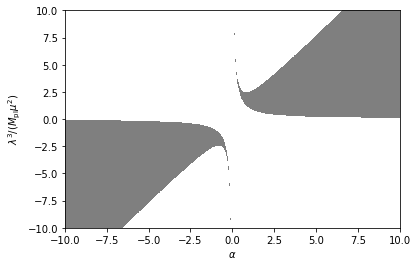

In [25]:
def m_sign(alpha, t3):
    return np.sign(m_factor(alpha, t3))

y, x = np.meshgrid(np.linspace(-10, 10, 1000), np.linspace(-10, 10, 1000))

z = -m_sign(x, y)

z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap = 'Greys', vmin = z_min, vmax = z_max, alpha = 0.5)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\lambda^3/(M_{\rm pl}\mu^2)$')
plt.show()

Now, we wish to understand the PTA constraint by adding to this plot. We setup the necessary functions below.

In [26]:
from scipy.constants import h, e

h_evs = h/e
h_evy = h_evs/(60*60*24*365.25) # hf at f = 1/year

def mc2(v, f_yr):
    return h_evy*f_yr*np.sqrt(1 - v**2)

# the mean, upper, lower limit effective mass (eV/c^2)
v_mean = 4.4250430E-01
v_low = 2.1807561E-02
v_upp = 5.8834640E-01
print('the mean, upper, lower limit effective mass (eV/c^2)')
print(mc2(v_mean, 1), mc2(v_upp, 1), mc2(v_low, 1))
print()

# r values taking \mu = 1e-22 eV-bare mass galileon
mu = 1e-22
print('r values taking \mu = 1e-22 eV-bare mass galileon')
print(mc2(v_mean, 1)/mu, mc2(v_upp, 1)/mu, mc2(v_low, 1)/mu)
print()

def L3m2(r, alpha):
    return (-2 + (2*(r**2)) + 3*(r**2)*(alpha**2))/(2*(-1 + (r**2))*alpha)

the mean, upper, lower limit effective mass (eV/c^2)
1.1752249090866566e-22 1.0596934232907577e-22 1.310202354050909e-22

r values taking \mu = 1e-22 eV-bare mass galileon
1.1752249090866567 1.0596934232907576 1.310202354050909



Then, we obtain the constrained parameter space, depending on the Galileon bare mass.

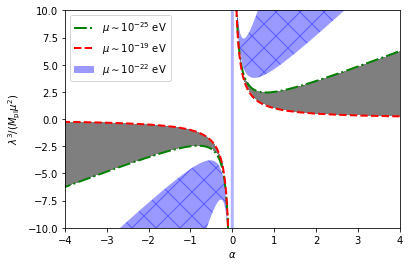

In [27]:
fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap = 'Greys', vmin = z_min, vmax = z_max, alpha = 0.5)

aspace = np.linspace(-10, 10, 1000)

# bare mass = 1e-22
ax.plot(aspace[495: 505], L3m2(mc2(v_mean, 1)/mu, aspace[495: 505]), 'b-', linewidth = 3, alpha = 0.3)
ax.fill_between(aspace, L3m2(mc2(v_mean, 1)/mu, aspace), L3m2(mc2(v_low, 1)/mu, aspace),
                color = 'blue', alpha = 0.4, edgecolor = 'none', hatch = 'x',
                label = r'$\mu \sim 10^{-22}$ eV')
ax.fill_between(aspace, L3m2(mc2(v_upp, 1)/mu, aspace), L3m2(mc2(v_mean, 1)/mu, aspace),
                color = 'blue', alpha = 0.4, edgecolor = 'none', hatch = 'x')

# r = 1e3
mu3 = 1e-25
ax.plot(aspace[:500], L3m2(mc2(v_mean, 1)/mu3, aspace[: 500]), 'g-.', linewidth = 2)
ax.plot(aspace[501:], L3m2(mc2(v_mean, 1)/mu3, aspace[501:]), 'g-.', linewidth = 2,
        label = r'$\mu \sim 10^{-25}$ eV')
ax.fill_between(aspace, L3m2(mc2(v_mean, 1)/mu3, aspace), L3m2(mc2(v_low, 1)/mu3, aspace),
                color = 'green', alpha = 0.4, edgecolor = 'none')
ax.fill_between(aspace, L3m2(mc2(v_upp, 1)/mu3, aspace), L3m2(mc2(v_mean, 1)/mu3, aspace),
                color = 'green', alpha = 0.4, edgecolor = 'none')

# r = 1e-3
mu2 = 1e-19
ax.plot(aspace[:500], L3m2(mc2(v_mean, 1)/mu2, aspace[: 500]), 'r--', linewidth = 2)
ax.plot(aspace[501:], L3m2(mc2(v_mean, 1)/mu2, aspace[501:]), 'r--', linewidth = 2,
        label = r'$\mu \sim 10^{-19}$ eV')
ax.fill_between(aspace, L3m2(mc2(v_mean, 1)/mu2, aspace), L3m2(mc2(v_low, 1)/mu2, aspace),
                color = 'red', alpha = 0.7, edgecolor = 'none')
ax.fill_between(aspace, L3m2(mc2(v_upp, 1)/mu2, aspace), L3m2(mc2(v_mean, 1)/mu2, aspace),
                color = 'red', alpha = 0.7, edgecolor = 'none')

# plot options
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\lambda^3/(M_{\rm pl}\mu^2)$')
ax.set_xlim(-4, 4)
ax.set_ylim(-10, 10)
plt.legend(loc = 'upper left', prop = {'size': 10})
plt.show()